In [1]:
# LIBRERIAS
import pandas as pd
import numpy as np
import math as math
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("df_final.csv")
del df["Unnamed: 0"]

Convertimos las variables "days_booked" y "reviews_diff" en las variables "booking_score" y "review_score".

In [3]:
# TRANSFORMACIÓN DE NUESTRAS VARIABLES RESPUESTA
df["days_booked"] = (df["days_booked"]/max(df["days_booked"])) * 5
df["reviews_diff"]  = (df["reviews_diff"]/12) * 5
df["reviews_diff"].where(df["reviews_diff"] <= 5, 5, inplace=True)
df["reviews_diff"].where(df["reviews_diff"] >= 0, 0, inplace=True)
df.rename(columns = {'days_booked':'booking_score', 'reviews_diff':'review_score'}, inplace = True)

Eliminamos variables que no seran útiles para el modelo como la latitud y longitud

In [4]:
df = df.drop(columns=['latitude', 'longitude'])

Definimos bien las variables.

In [5]:
df[df.select_dtypes("object").columns] = df.select_dtypes("object").astype("category")

In [6]:
df[df.iloc[:,27:89].columns] = df[df.iloc[:,27:89].columns].astype("int")
df[df.iloc[:,4:8].columns] = df[df.iloc[:,4:8].columns].astype("int")
df[df.iloc[:,16:24].columns] = df[df.iloc[:,16:24].columns].astype("int")

In [7]:
df = df.drop(columns=['id','host_id'])

Prepararemos ahora el data frame de manera que tendremos un data frame sin las dos variables respuesta y dos vectores con las variables respuesta.

In [8]:
y1 = df["booking_score"]
y2 = df["review_score"]
X = df.drop(columns=['booking_score', 'review_score'])

In [9]:
df.to_csv("E:\Data\TFG\df_modelo.csv")

Antes tenemos que aplicar One Hot Encoding en las variables categoricas para que de esta manera podamos ejecutar el XGBoost.

In [10]:
# TRANSFORMACION ONE HOT ENCODING
X_cat = X.select_dtypes("category")
encoder = OneHotEncoder()
encoded_x_array = encoder.fit_transform(X_cat[X_cat.columns])
colnames = encoder.get_feature_names(X_cat.columns)
encoded_x =  pd.DataFrame(encoded_x_array.todense(), columns = colnames)

c:\Users\Andreu\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [11]:
math.fsum(encoded_x.loc[1,:])

13.0

In [12]:
X = X.drop(columns = X.select_dtypes("category").columns)
X = pd.concat([X,pd.DataFrame(encoded_x)], axis = 1)

Passamos ahora a aplicar el XGBoost. Empezamos por "booking_score" y1

In [13]:
data_dmatrix = xgb.DMatrix(data=X,label=y1)

In [14]:
X_train, X_test, y1_train, y1_test = train_test_split(X, y1, test_size=0.2, random_state=123)

In [15]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.05, max_depth = 10, alpha = 10, n_estimators = 1000)

In [16]:
xg_reg.fit(X_train,y1_train)
preds = xg_reg.predict(X_test)
preds_train = xg_reg.predict(X_train)

[11:35:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


In [17]:
rmse = np.sqrt(mean_squared_error(y1_test, preds))
print("RMSE: %f" % (rmse))
rmse = np.sqrt(mean_squared_error(y1_train, preds_train))
print("RMSE: %f" % (rmse))

RMSE: 1.312855
RMSE: 0.486197


In [18]:
params = {'objective':'reg:linear',
          'max_depth': 10,
          'learning_rate': 0.05,
          'colsample_bytree': 0.3}

data_dmatrix = xgb.DMatrix(data=X,label=y1)

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5, num_boost_round=1000, early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

[11:35:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[11:35:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[11:35:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[11:35:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[11:35:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


In [19]:
cv_results.tail()

train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
551         0.502610        0.017355        1.339522       0.018415
552         0.502182        0.017179        1.339512       0.018379
553         0.502133        0.017160        1.339500       0.018384
554         0.501911        0.017273        1.339492       0.018389
555         0.501666        0.017426        1.339469       0.018354

c:\Users\Andreu\miniconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 2309 (\N{DEVANAGARI LETTER A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Andreu\miniconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Andreu\miniconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 2342 (\N{DEVANAGARI LETTER DA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Andreu\miniconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 2366 (\N{DEVANAGARI VOWEL SIGN AA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Andreu\miniconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 2357 (\N{DEVANAGARI LETTER VA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Andreu\mi

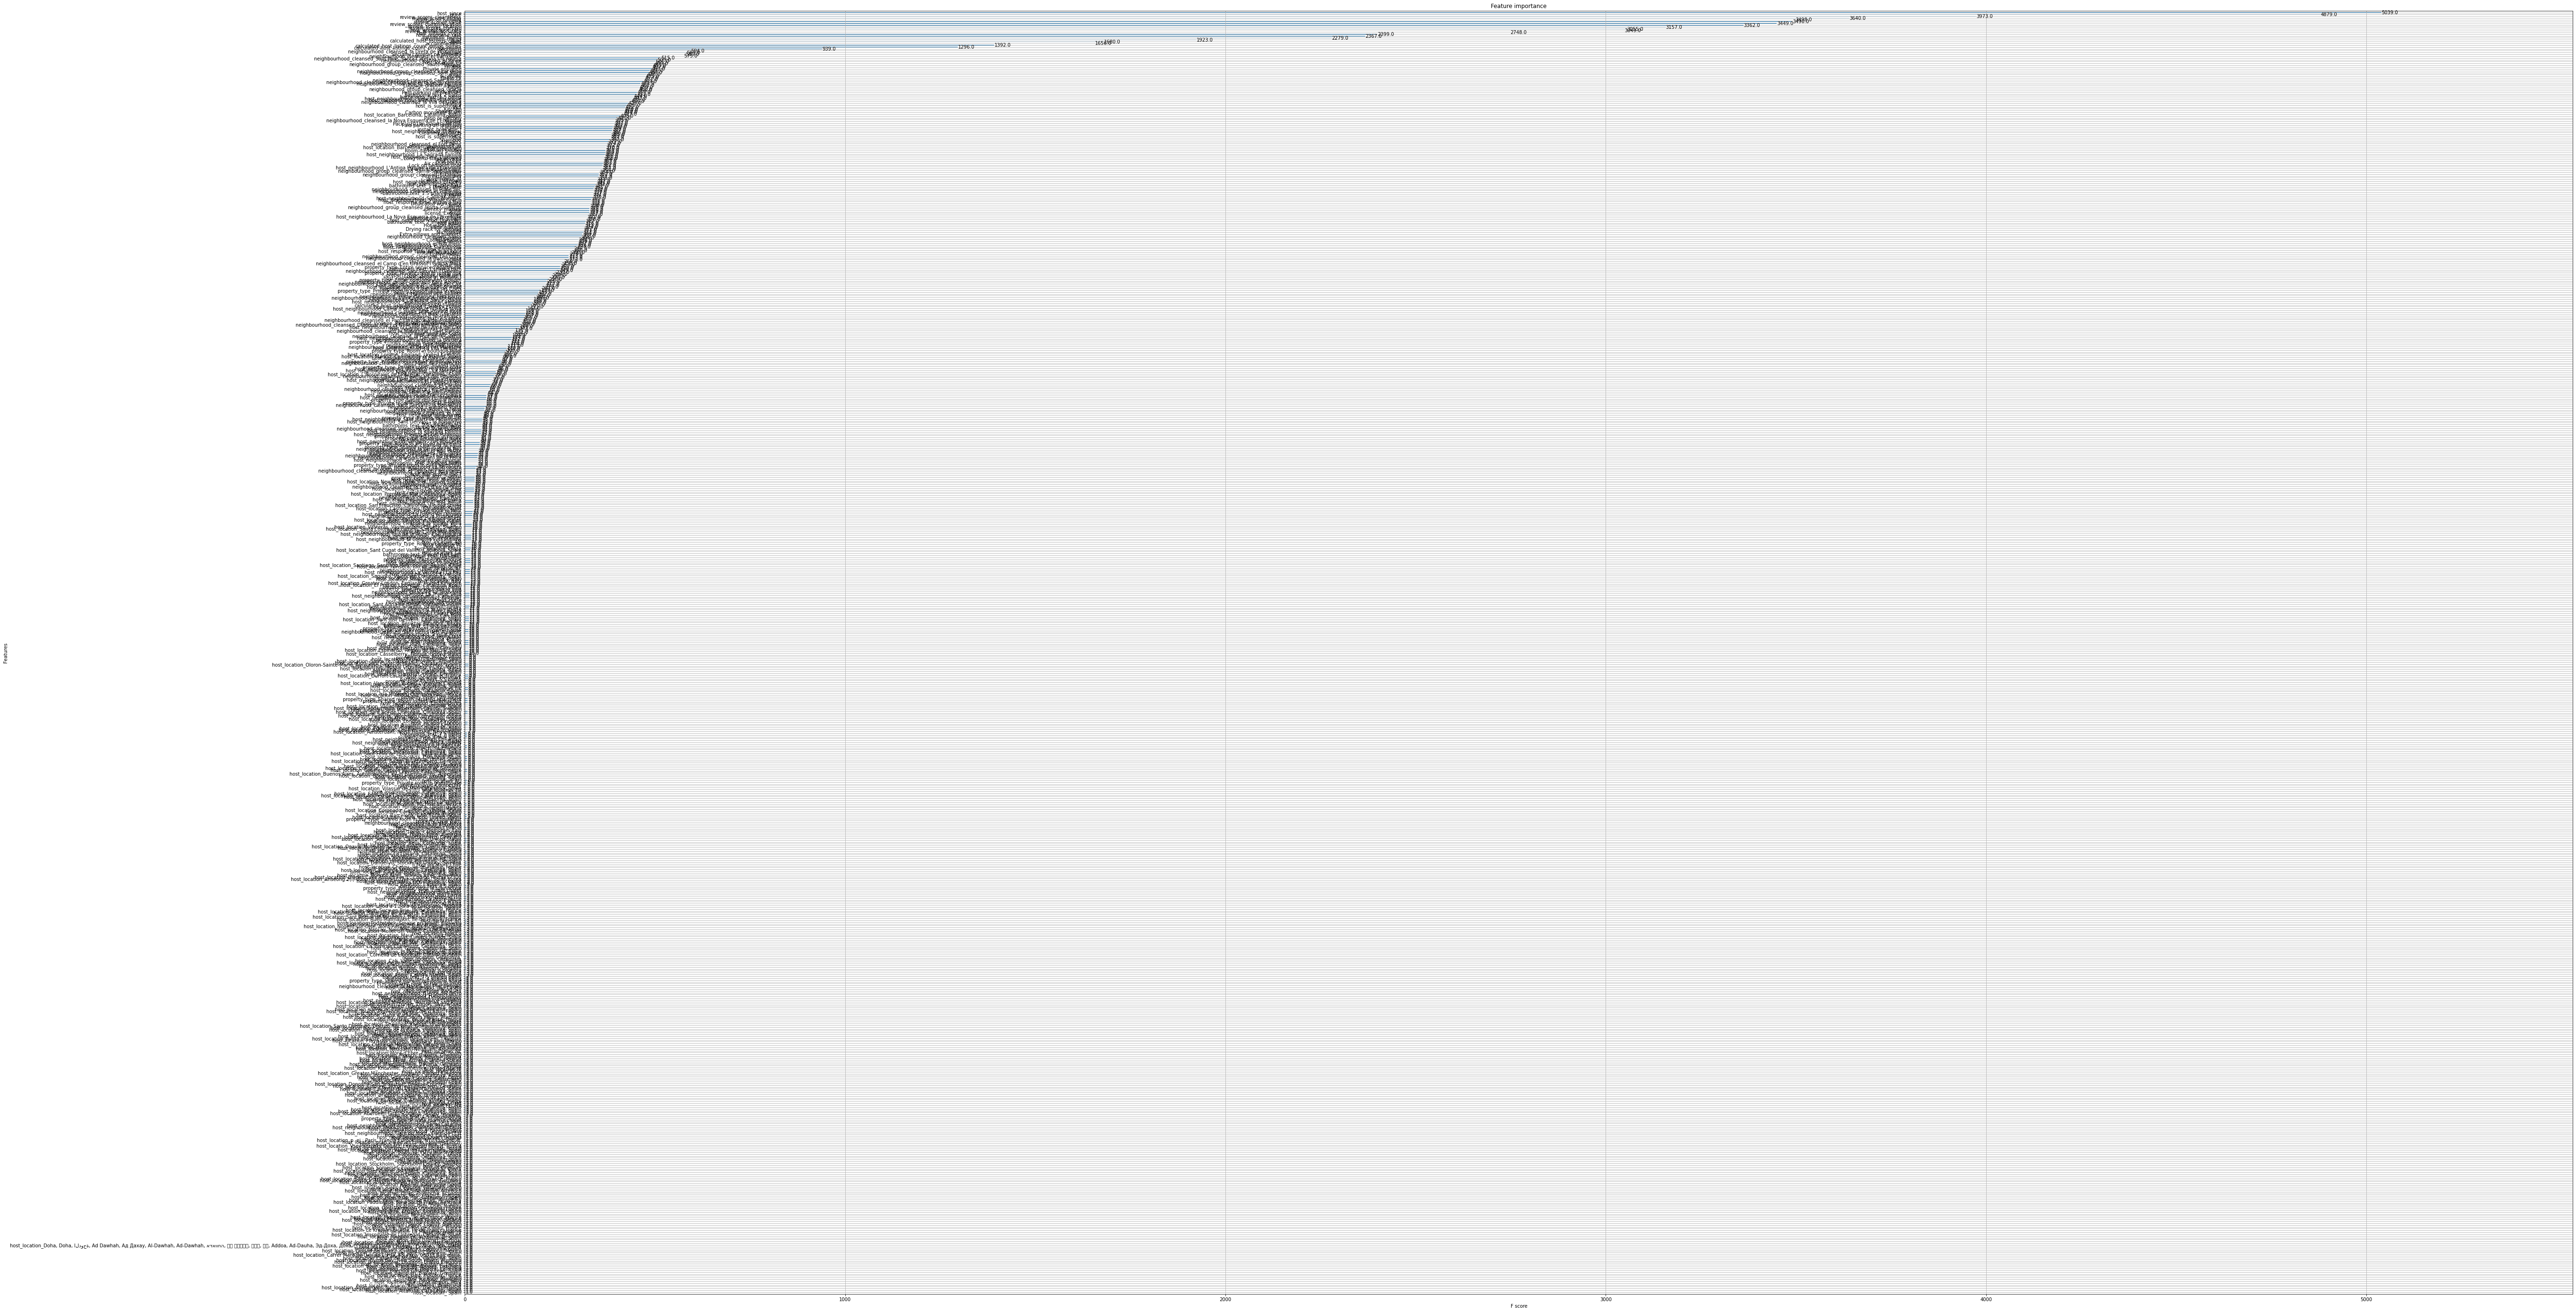

In [20]:
plt.rcParams['figure.figsize'] = [80, 50]
xgb.plot_importance(xg_reg)
plt.show()

Hacemos selección de las variables más importantes para hacer un modelo nuevo y ver si conseguimos bajar el overfitting y mantener o mejorar el error.

In [21]:
# select features using threshold
selection = SelectFromModel(xg_reg, threshold=0.002, prefit=True)
select_X_train = selection.transform(X_train)
feature_idx = selection.get_support()
select_X_train = pd.DataFrame(select_X_train, columns=X.columns[feature_idx])

# train model
selection_model = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 10, alpha = 10, n_estimators = 1000)
selection_model.fit(select_X_train, y1_train)

# eval model
select_X_test = selection.transform(X_test)
y1_pred = selection_model.predict(select_X_test)
train_pred = selection_model.predict(select_X_train)
select_X_test = pd.DataFrame(select_X_test, columns=X.columns[feature_idx])

rmse = np.sqrt(mean_squared_error(y1_test, y1_pred))
print("RMSE: %f" % (rmse))
rmse = np.sqrt(mean_squared_error(y1_train, train_pred))
print("RMSE: %f" % (rmse))

c:\Users\Andreu\miniconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


[11:41:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 1.392191
RMSE: 1.148345


c:\Users\Andreu\miniconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [22]:
selected_X = X.loc[:,selection.get_support()]

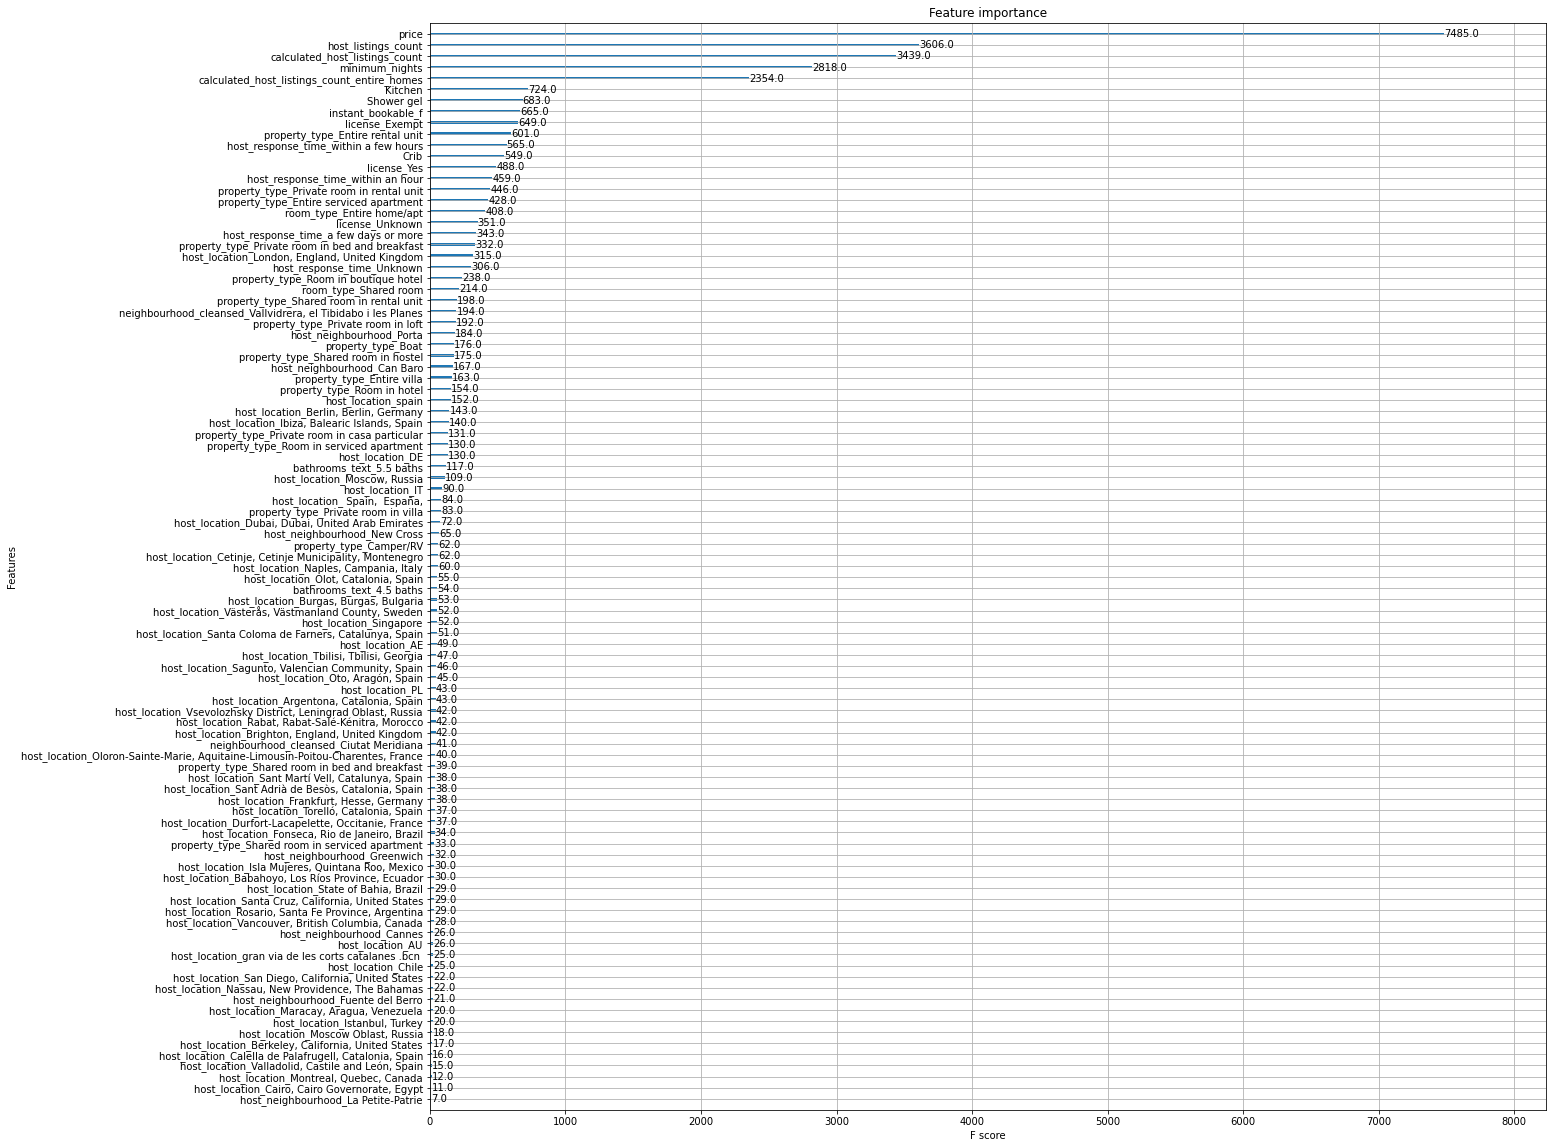

In [23]:
plt.rcParams['figure.figsize'] = [20, 20]
xgb.plot_importance(selection_model)
plt.show()

Pasamos a la optimización de los hiperparametros.

In [24]:
params = { 'max_depth': [10,12,15],
           'learning_rate': [0.01, 0.03, 0.05, 0.075],
           'n_estimators': [750, 1000, 1250, 1500],
           'colsample_bytree': [0.3, 0.45]}

xgbr = xgb.XGBRegressor(seed = 123)

clf = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=1)

clf.fit(selected_X, y1)

print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best parameters: {'colsample_bytree': 0.3, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 1000}
Lowest RMSE:  1.4975134743956868


Best parameters: {'colsample_bytree': 0.3, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 1000}

In [24]:
params = {'objective':'reg:linear',
          'max_depth': 10,
          'learning_rate': 0.01,
          'colsample_bytree': 0.3}

data_dmatrix = xgb.DMatrix(data=selected_X,label=y1)

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3, num_boost_round=1000, early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

[11:42:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[11:42:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[11:42:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


In [25]:
cv_results.tail()

train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
902         1.105959        0.017437        1.421092       0.023290
903         1.105829        0.017348        1.421079       0.023291
904         1.105775        0.017393        1.421049       0.023261
905         1.105769        0.017392        1.421050       0.023258
906         1.105746        0.017410        1.421048       0.023249

Volvemos a recortar el número de variables para ver si podemos así reducir más el overfitting.

In [26]:
# select features using threshold
selection = SelectFromModel(selection_model, threshold=0.003, prefit=True)
select_X_train2 = selection.transform(select_X_train)
feature_idx = selection.get_support()
select_X_train2 = pd.DataFrame(select_X_train2, columns=selected_X.columns[feature_idx])

# train model
selection_model2 = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 10, alpha = 10, n_estimators = 1000)
selection_model2.fit(select_X_train2, y1_train)

# eval model
select_X_test2 = selection.transform(select_X_test)
y1_pred2 = selection_model2.predict(select_X_test2)
train_pred2 = selection_model2.predict(select_X_train2)
select_X_test2 = pd.DataFrame(select_X_test2, columns=selected_X.columns[feature_idx])

rmse = np.sqrt(mean_squared_error(y1_test, y1_pred2))
print("RMSE: %f" % (rmse))
rmse = np.sqrt(mean_squared_error(y1_train, train_pred2))
print("RMSE: %f" % (rmse))

c:\Users\Andreu\miniconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


[11:46:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 1.394695
RMSE: 1.133383


c:\Users\Andreu\miniconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [27]:
selected_X2 = selected_X.loc[:,selection.get_support()]

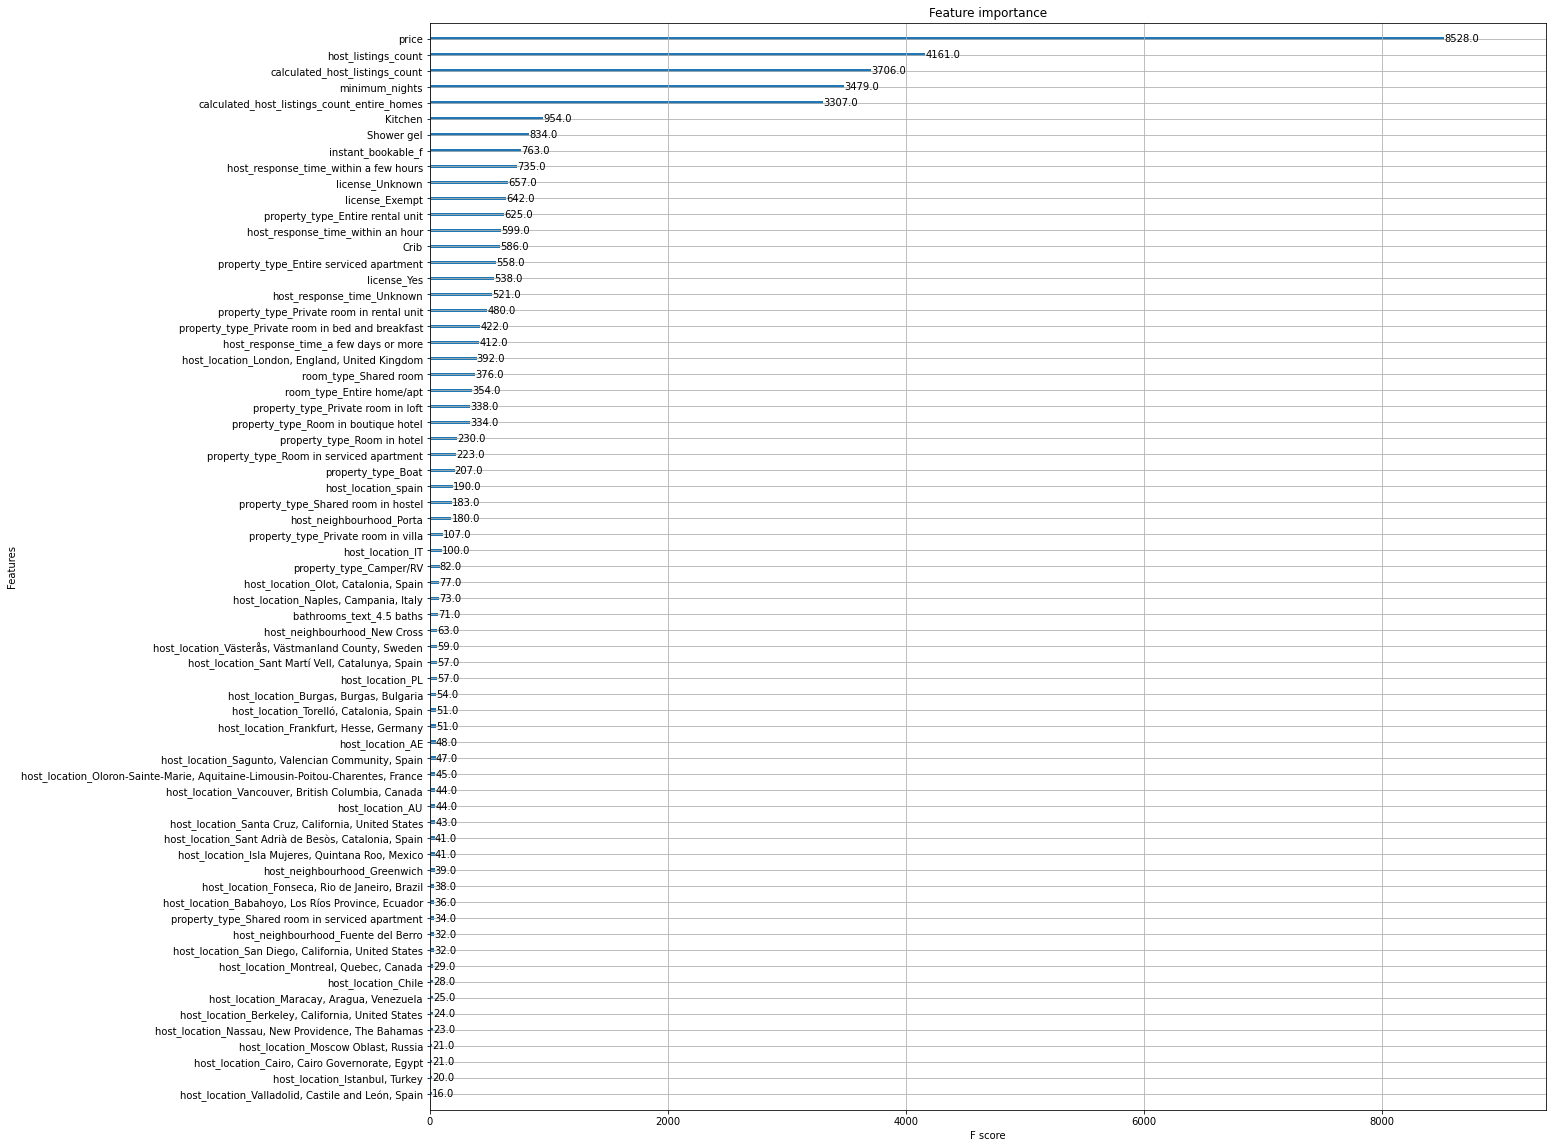

In [28]:
plt.rcParams['figure.figsize'] = [20, 20]
xgb.plot_importance(selection_model2)
plt.show()

Pasamos a la optimización de los hiperparametros.

In [30]:
params = { 'max_depth': [8, 10, 12, 15],
           'learning_rate': [0.01, 0.03, 0.05, 0.075],
           'n_estimators': [750, 1000, 1250, 1500],
           'colsample_bytree': [0.3, 0.45]}

xgbr = xgb.XGBRegressor(seed = 123)

clf = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=1)

clf.fit(selected_X2, y1)

print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

Fitting 5 folds for each of 128 candidates, totalling 640 fits
Best parameters: {'colsample_bytree': 0.45, 'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 1500}
Lowest RMSE:  1.4973205104132352


Best parameters: {'colsample_bytree': 0.45, 'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 1500}
Lowest RMSE:  1.4973205104132352

In [29]:
params = {'objective':'reg:linear',
          'max_depth': 8,
          'learning_rate': 0.01,
          'colsample_bytree': 0.45}

data_dmatrix = xgb.DMatrix(data=selected_X2,label=y1)

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5, num_boost_round=1500, early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

[11:47:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[11:47:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[11:47:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[11:47:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[11:47:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


In [30]:
cv_results.tail()

train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
1004         1.217730        0.013191        1.416342       0.021988
1005         1.217666        0.013213        1.416345       0.021988
1006         1.217594        0.013263        1.416324       0.021957
1007         1.217517        0.013324        1.416304       0.021953
1008         1.217414        0.013400        1.416290       0.021942

In [33]:
params = { 'max_depth': [5,6,8,9],
           'learning_rate': [0.01, 0.03, 0.05],
           'n_estimators': [1250, 1500, 1550, 1600],
           'colsample_bytree': [0,35,0.45]}

xgbr = xgb.XGBRegressor(seed = 123)

clf = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=1)

clf.fit(selected_X2, y1)

print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

Fitting 5 folds for each of 144 candidates, totalling 720 fits


c:\Users\Andreu\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
240 fits failed out of a total of 720.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
240 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Andreu\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Andreu\miniconda3\lib\site-packages\xgboost\core.py", line 532, in inner_f
    return f(**kwargs)
  File "c:\Users\Andreu\miniconda3\lib\site-packages\xgboost\sklearn.py", line 961, in fit
    self._Booster = train(
  File "c:\Users\Andreu\miniconda3\lib\site-packages\xgboost\core.py",

Best parameters: {'colsample_bytree': 0.45, 'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 1600}
Lowest RMSE:  1.4972315123123352


Best parameters: {'colsample_bytree': 0.45, 'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 1600}
Lowest RMSE:  1.4972315123123352

In [34]:
params = { 'max_depth': [7,8],
           'learning_rate': [0.005,0.01],
           'n_estimators': [1800,1900,2000],
           'colsample_bytree': [0.35,0.45]}

xgbr = xgb.XGBRegressor(seed = 123)

clf = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=1)

clf.fit(selected_X2, y1)

print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'colsample_bytree': 0.45, 'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 1800}
Lowest RMSE:  1.4964992692394663


Best parameters: {'colsample_bytree': 0.45, 'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 1800}
Lowest RMSE:  1.4964992692394663

In [31]:
params = {'objective':'reg:linear',
          'max_depth': 8,
          'learning_rate': 0.01,
          'colsample_bytree': 0.45}

data_dmatrix = xgb.DMatrix(data=selected_X2,label=y1)

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5, num_boost_round=1800, early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

[11:51:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[11:51:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[11:51:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[11:51:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[11:51:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


In [32]:
cv_results.tail()

train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
1004         1.217730        0.013191        1.416342       0.021988
1005         1.217666        0.013213        1.416345       0.021988
1006         1.217594        0.013263        1.416324       0.021957
1007         1.217517        0.013324        1.416304       0.021953
1008         1.217414        0.013400        1.416290       0.021942

Pasamos a hacer una ultima prueba donde seremos más estrictos con el threshold y nos quedaremos solo con las más importantes.

In [67]:
# select features using threshold
selection = SelectFromModel(selection_model2, threshold=0.0079, prefit=True)
select_X_train3 = selection.transform(select_X_train2)
feature_idx = selection.get_support()
select_X_train3 = pd.DataFrame(select_X_train3, columns=selected_X2.columns[feature_idx])

# train model
selection_model3 = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 10, alpha = 10, n_estimators = 1000)
selection_model3.fit(select_X_train3, y1_train)

# eval model
select_X_test3 = selection.transform(select_X_test2)
y1_pred3 = selection_model3.predict(select_X_test3)
train_pred3 = selection_model3.predict(select_X_train3)
select_X_test3 = pd.DataFrame(select_X_test3, columns=selected_X2.columns[feature_idx])

rmse = np.sqrt(mean_squared_error(y1_test, y1_pred3))
print("RMSE: %f" % (rmse))
rmse = np.sqrt(mean_squared_error(y1_train, train_pred3))
print("RMSE: %f" % (rmse))

c:\Users\Andreu\miniconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


[12:05:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 1.398481
RMSE: 1.170560


c:\Users\Andreu\miniconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [68]:
selected_X3 = selected_X2.loc[:,selection.get_support()]

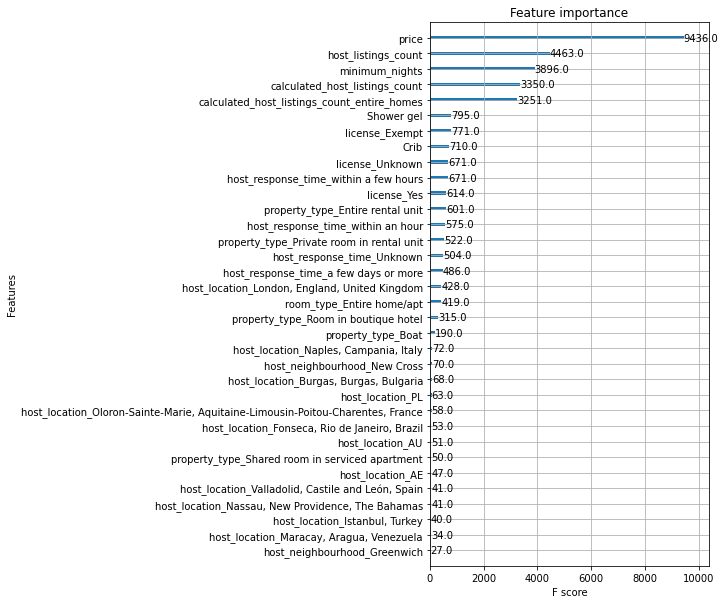

In [79]:
plt.rcParams['figure.figsize'] = [5, 10]
xgb.plot_importance(selection_model3)
plt.show()

In [36]:
params = { 'max_depth': [7,8,10],
           'learning_rate': [0.005,0.01,0.02, 0.05],
           'n_estimators': [1700,1800,1900,2000],
           'colsample_bytree': [0.35,0.45]}

xgbr = xgb.XGBRegressor(seed = 123)

clf = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=1)

clf.fit(selected_X3, y1)

print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

Fitting 5 folds for each of 96 candidates, totalling 480 fits


KeyboardInterrupt: 

Best parameters: {'colsample_bytree': 0.45, 'learning_rate': 0.005, 'max_depth': 7, 'n_estimators': 2000}
Lowest RMSE:  1.5366471173407537

In [42]:
params = { 'max_depth': [5,6,7],
           'learning_rate': [0.005,0.01,0.02],
           'n_estimators': [2000,2100,2200],
           'colsample_bytree': [0.35,0.45]}

xgbr = xgb.XGBRegressor(seed = 123)

clf = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=1)

clf.fit(selected_X3, y1)

print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best parameters: {'colsample_bytree': 0.45, 'learning_rate': 0.005, 'max_depth': 7, 'n_estimators': 2100}
Lowest RMSE:  1.5366405003810721


In [70]:
params = {'objective':'reg:linear',
          'max_depth': 7,
          'learning_rate': 0.005,
          'colsample_bytree': 0.45}

data_dmatrix = xgb.DMatrix(data=selected_X3,label=y1)

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5, num_boost_round=2100, early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

[12:45:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[12:45:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[12:45:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[12:45:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[12:45:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


In [71]:
cv_results.tail()

train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
2095         1.266972        0.007728        1.429790       0.024587
2096         1.266925        0.007712        1.429792       0.024587
2097         1.266889        0.007728        1.429780       0.024587
2098         1.266845        0.007725        1.429768       0.024597
2099         1.266820        0.007736        1.429755       0.024586

In [45]:
params = { 'max_depth': [7,8,9,10],
           'learning_rate': [0.005,0.01,0.02],
           'n_estimators': [100,150,200,250],
           'colsample_bytree': [0.35,0.45]}

xgbr = xgb.XGBRegressor(seed = 123)

clf = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=1)

clf.fit(selected_X3, y1)

print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best parameters: {'colsample_bytree': 0.45, 'learning_rate': 0.02, 'max_depth': 9, 'n_estimators': 250}
Lowest RMSE:  1.5375161142658171


In [72]:
params = {'objective':'reg:linear',
          'max_depth': 7,
          'learning_rate': 0.05,
          'colsample_bytree': 0.45}

data_dmatrix = xgb.DMatrix(data=selected_X3,label=y1)

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5, num_boost_round=2100, early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

[12:46:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[12:46:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[12:46:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[12:46:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[12:46:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


In [73]:
cv_results.tail()

train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
424         1.176856        0.005185        1.423103       0.025151
425         1.176589        0.005086        1.423151       0.025154
426         1.176149        0.005134        1.423087       0.025070
427         1.175779        0.005031        1.423030       0.025010
428         1.175664        0.005028        1.423012       0.024997

Observamos el mejor resultado para la base de datos "selected_X3" y con los parametros: {'colsample_bytree': 0.45, 'learning_rate': 0.005, 'max_depth': 7, 'n_estimators': 2100}.
Por lo tanto procedemos a guardar como csv esta base de datos para evitar tener que volver a cargar todo este script y, sabemos que tendremos que utilizarlos con los parametros mencionados anteriormente.

In [74]:
selected_X3.to_csv("E:\Data\TFG\X_y1.csv")

Pasamos ahora a buscar el modelo optimo para la segunda variable respuesta "reviews_score" la cual denominaremos como "y2"

In [80]:
data_dmatrix = xgb.DMatrix(data=X,label=y2)

In [81]:
X_train, X_test, y2_train, y2_test = train_test_split(X, y2, test_size=0.2, random_state=123)

In [82]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.05, max_depth = 10, alpha = 10, n_estimators = 1000)

In [83]:
xg_reg.fit(X_train,y2_train)
preds = xg_reg.predict(X_test)
preds_train = xg_reg.predict(X_train)

[18:41:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


In [84]:
rmse = np.sqrt(mean_squared_error(y2_test, preds))
print("RMSE: %f" % (rmse))
rmse = np.sqrt(mean_squared_error(y2_train, preds_train))
print("RMSE: %f" % (rmse))

RMSE: 0.943512
RMSE: 0.381226


Como para la variable y2 parece que se observa un fuerte overfitting, el cual intentaremos reducir como visto anteriormente a traves de reducir las dimensiones de la base de datos. Utilizaremos CV para confirmar.

In [85]:
params = {'objective':'reg:linear',
          'max_depth': 10,
          'learning_rate': 0.05,
          'colsample_bytree': 0.3}

data_dmatrix = xgb.DMatrix(data=X,label=y2)

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5, num_boost_round=1000, early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

[18:43:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[18:43:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[18:43:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[18:43:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[18:43:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


In [86]:
cv_results.tail()

train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
444         0.213093        0.012971        0.950208       0.013619
445         0.212706        0.012874        0.950181       0.013654
446         0.212314        0.013007        0.950158       0.013628
447         0.212100        0.013071        0.950134       0.013624
448         0.211783        0.013054        0.950134       0.013630

Despues de ver los resultados de la CV observamos que tenemos un claro problema de overfitting.

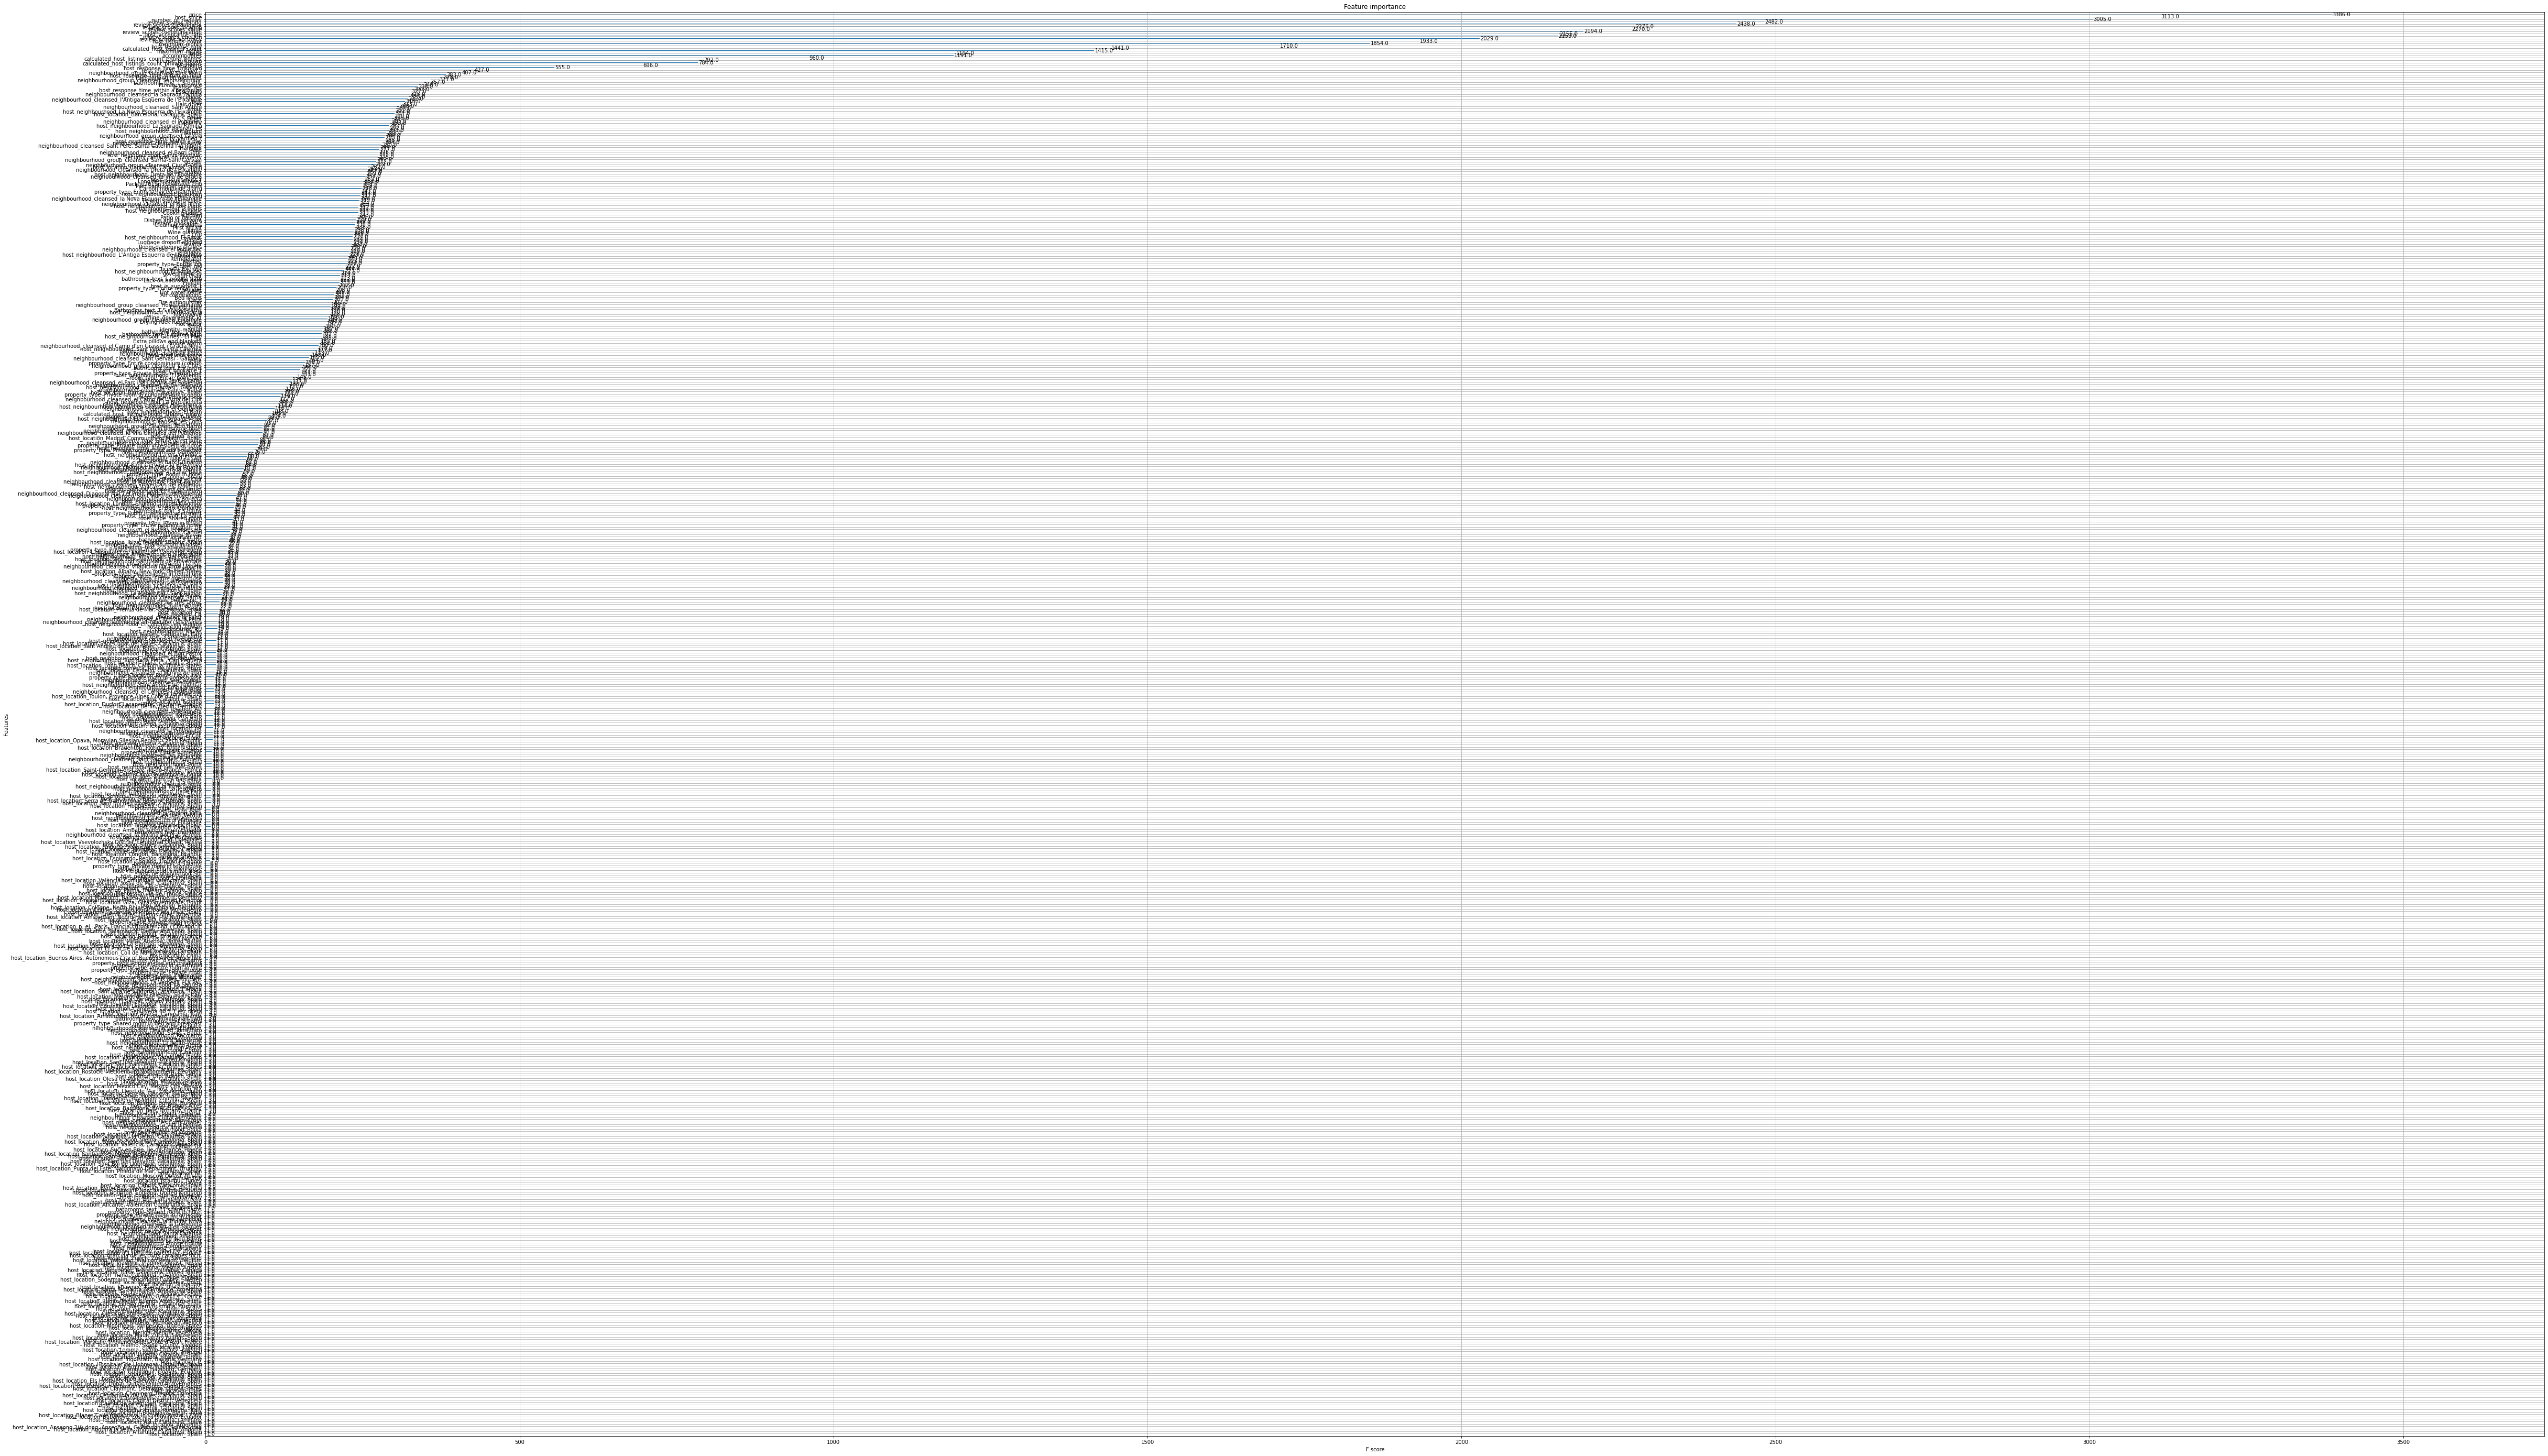

In [87]:
plt.rcParams['figure.figsize'] = [80, 50]
xgb.plot_importance(xg_reg)
plt.show()

Como hemos visto anteriormente procedemos a utilizar la función SelectFromModel() para deshacernos de las variables menos útiles del modelo.

In [88]:
# select features using threshold
selection = SelectFromModel(xg_reg, threshold=0.002, prefit=True)
select_X_train = selection.transform(X_train)
feature_idx = selection.get_support()
select_X_train = pd.DataFrame(select_X_train, columns=X.columns[feature_idx])

# train model
selection_model = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 10, alpha = 10, n_estimators = 1000)
selection_model.fit(select_X_train, y2_train)

# eval model
select_X_test = selection.transform(X_test)
y2_pred = selection_model.predict(select_X_test)
train_pred = selection_model.predict(select_X_train)
select_X_test = pd.DataFrame(select_X_test, columns=X.columns[feature_idx])

rmse = np.sqrt(mean_squared_error(y2_test, y2_pred))
print("RMSE: %f" % (rmse))
rmse = np.sqrt(mean_squared_error(y2_train, train_pred))
print("RMSE: %f" % (rmse))

c:\Users\Andreu\miniconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


[18:47:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 0.973305
RMSE: 0.407053


c:\Users\Andreu\miniconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [89]:
selected_X = X.loc[:,selection.get_support()]
selected_X.shape

(13252, 123)

Vemos que las dimensiones de esta matriz son de (13252,123)

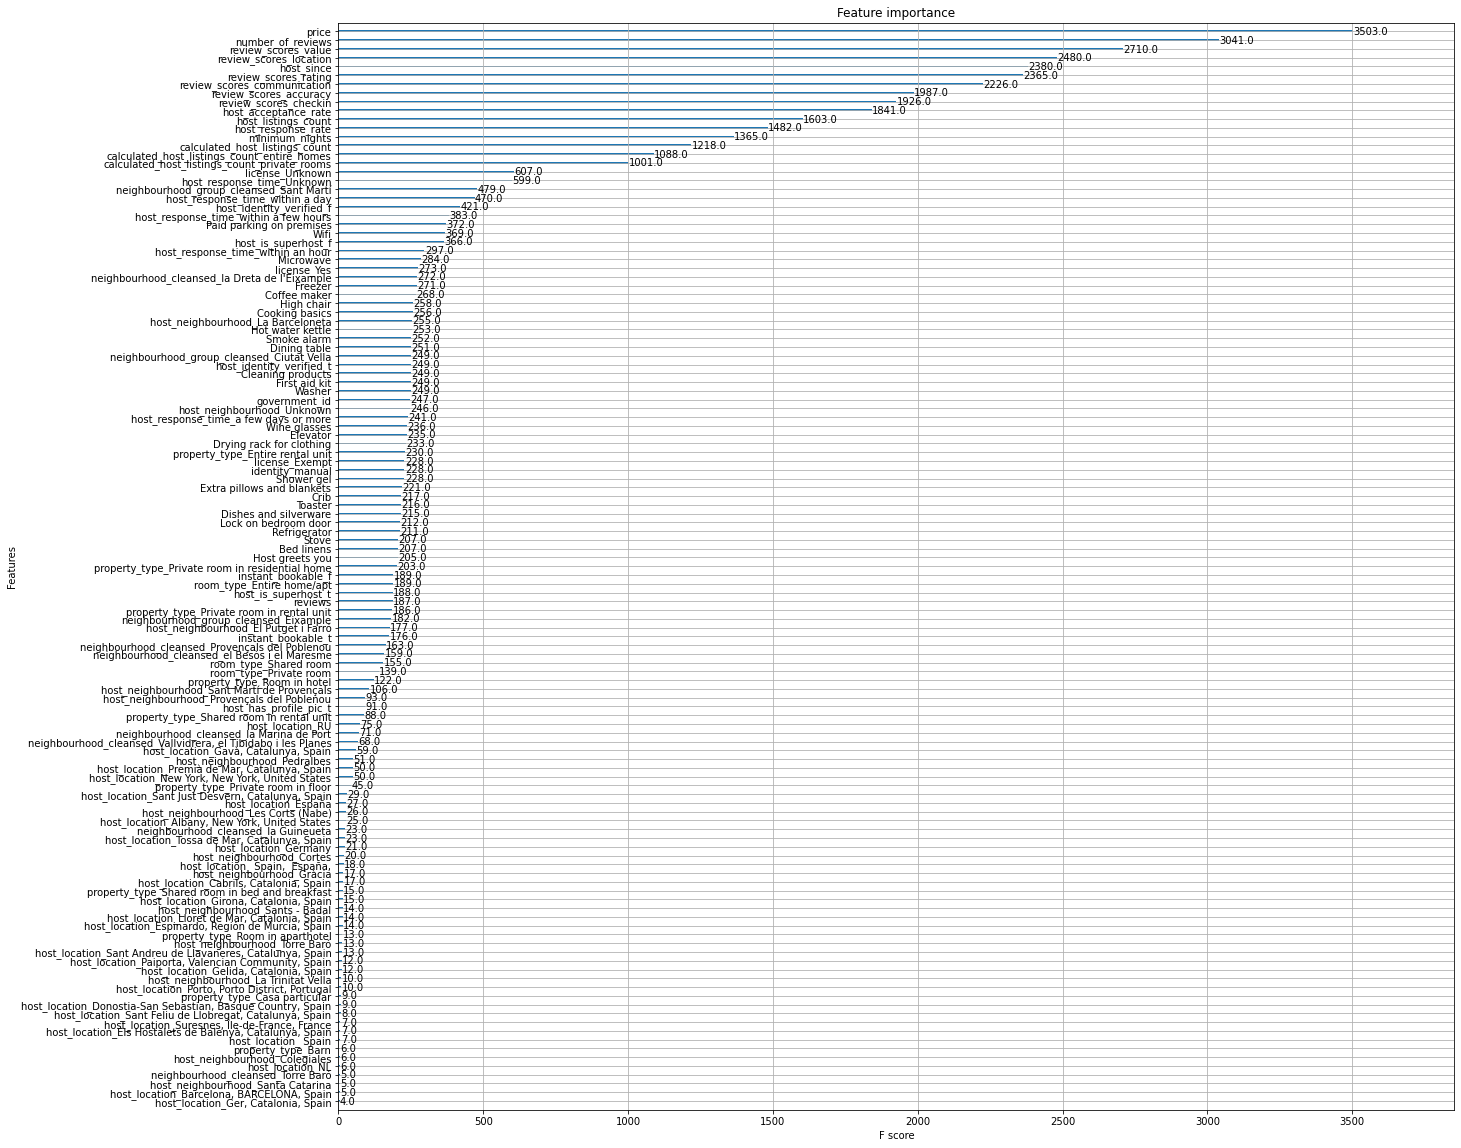

In [90]:
plt.rcParams['figure.figsize'] = [20, 20]
xgb.plot_importance(selection_model)
plt.show()

In [49]:
params = { 'max_depth': [10,12,15],
           'learning_rate': [0.01, 0.03, 0.05, 0.075],
           'n_estimators': [750, 1000, 1250, 1500],
           'colsample_bytree': [0.3, 0.45]}

xgbr = xgb.XGBRegressor(seed = 123)

clf = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=1)

clf.fit(selected_X, y2)

print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best parameters: {'colsample_bytree': 0.45, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 1500}
Lowest RMSE:  1.0424662938550286


Best parameters: {'colsample_bytree': 0.45, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 1500}

Probaremos ahora a augmentar el numero de estimadores.

In [50]:
params = { 'max_depth': [8,10],
           'learning_rate': [0.01],
           'n_estimators': [1500,1600,1700],
           'colsample_bytree': [0.35,0.45]}

xgbr = xgb.XGBRegressor(seed = 123)

clf = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=1)

clf.fit(selected_X, y2)

print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'colsample_bytree': 0.35, 'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 1700}
Lowest RMSE:  1.0389029412589221


Best parameters: {'colsample_bytree': 0.35, 'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 1700}

Observamos que el numero de estimadores sube y la profundidad máxima baja, con lo que volvemos a realizar otro GridSearch centrandonos en estos dos parametros.

In [51]:
params = { 'max_depth': [6,7,8],
           'learning_rate': [0.01],
           'n_estimators': [1700,1800,1900],
           'colsample_bytree': [0.35,0.45]}

xgbr = xgb.XGBRegressor(seed = 123)

clf = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=1)

clf.fit(selected_X, y2)

print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters: {'colsample_bytree': 0.35, 'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 1900}
Lowest RMSE:  1.0386113516039284


Best parameters: {'colsample_bytree': 0.35, 'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 1900}

In [91]:
params = {'objective':'reg:linear',
          'max_depth': 8,
          'learning_rate': 0.01,
          'colsample_bytree': 0.35}

data_dmatrix = xgb.DMatrix(data=selected_X,label=y2)

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5, num_boost_round=1900, early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

[18:49:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[18:49:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[18:49:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[18:49:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[18:49:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


In [92]:
cv_results.tail()

train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
1236         0.473955        0.009233        0.935049       0.012238
1237         0.473760        0.009232        0.935050       0.012246
1238         0.473507        0.009112        0.935017       0.012256
1239         0.473407        0.009124        0.935024       0.012255
1240         0.473304        0.009140        0.935016       0.012260

Volvemos ahora a quitar más variables.

In [93]:
# select features using threshold
selection = SelectFromModel(selection_model, threshold=0.003, prefit=True)
select_X_train2 = selection.transform(select_X_train)
feature_idx = selection.get_support()
select_X_train2 = pd.DataFrame(select_X_train2, columns=selected_X.columns[feature_idx])

# train model
selection_model2 = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.35, learning_rate = 0.01, max_depth = 8, n_estimators = 1900)
selection_model2.fit(select_X_train2, y2_train)

# eval model
select_X_test2 = selection.transform(select_X_test)
y2_pred2 = selection_model2.predict(select_X_test2)
train_pred2 = selection_model2.predict(select_X_train2)
select_X_test2 = pd.DataFrame(select_X_test2, columns=selected_X.columns[feature_idx])

rmse = np.sqrt(mean_squared_error(y2_test, y2_pred2))
print("RMSE: %f" % (rmse))
rmse = np.sqrt(mean_squared_error(y2_train, train_pred2))
print("RMSE: %f" % (rmse))

c:\Users\Andreu\miniconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


[18:51:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


c:\Users\Andreu\miniconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


RMSE: 0.948039
RMSE: 0.387196


In [94]:
selected_X2 = selected_X.loc[:,selection.get_support()]
selected_X2.shape

(13252, 81)

Vemos que las dimensiones de esta nueva matriz son de (13252, 81)

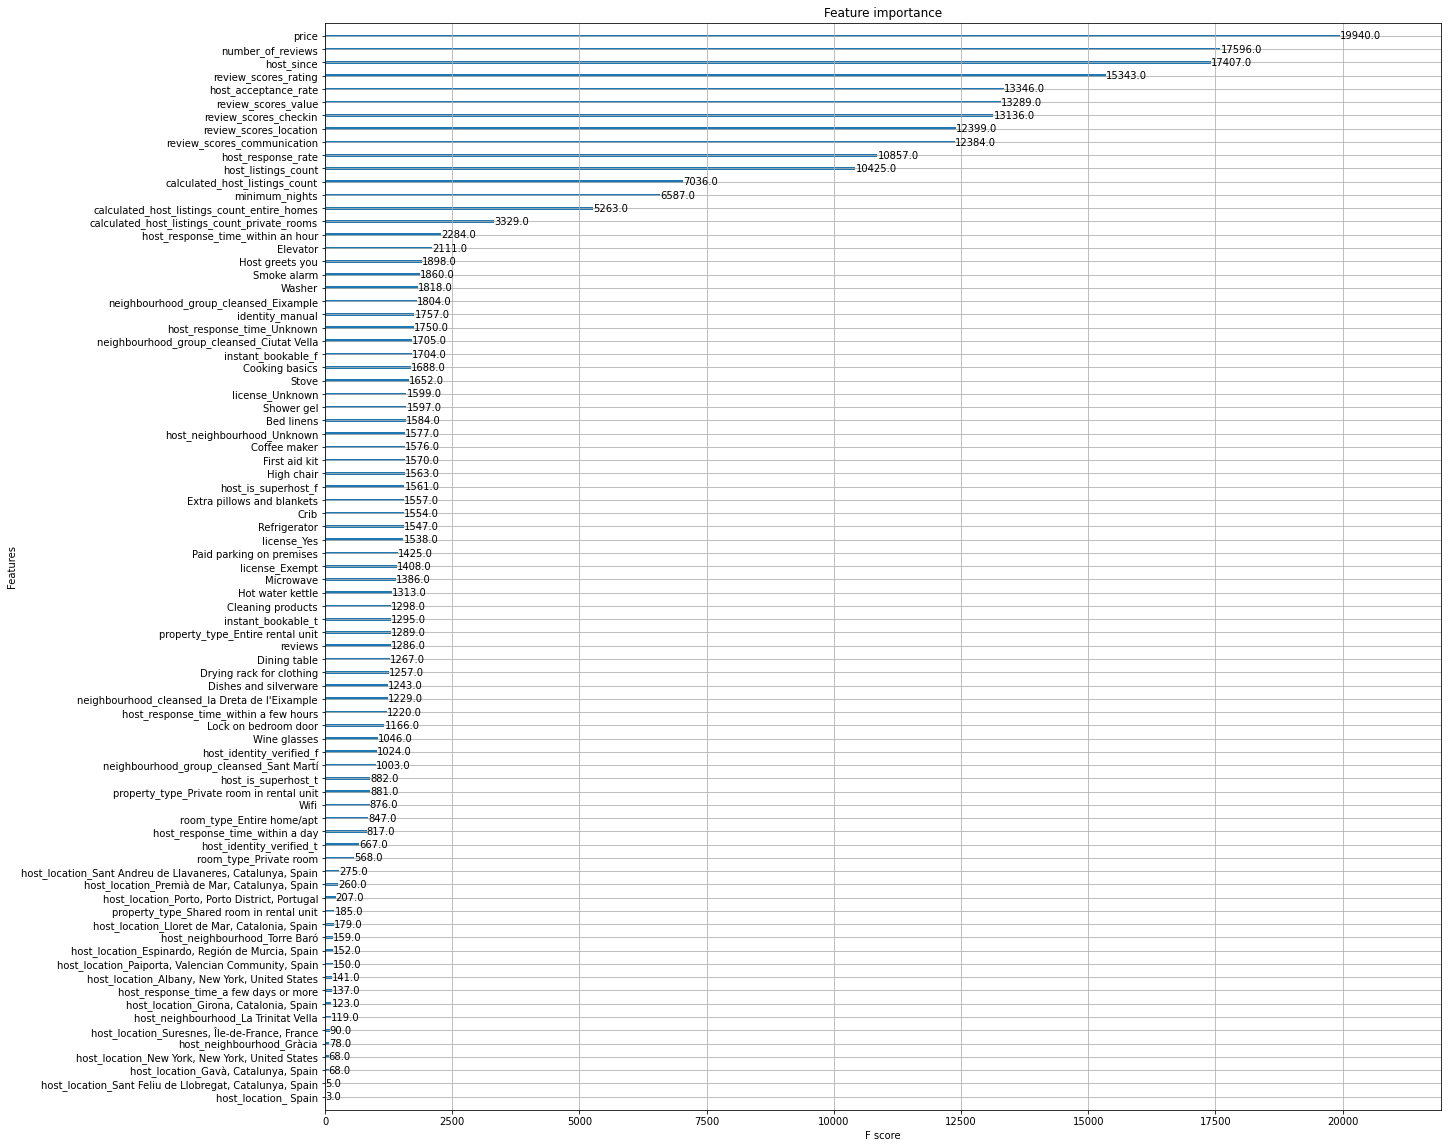

In [95]:
plt.rcParams['figure.figsize'] = [20, 20]
xgb.plot_importance(selection_model2)
plt.show()

In [59]:
params = { 'max_depth': [8,10],
           'learning_rate': [0.01,0.03,0.05],
           'n_estimators': [1500,1700,1900],
           'colsample_bytree': [0.3,0.35,0.45]}

xgbr = xgb.XGBRegressor(seed = 123)

clf = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=1)

clf.fit(selected_X2, y2)

print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best parameters: {'colsample_bytree': 0.45, 'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 1700}
Lowest RMSE:  1.0420232771865272


Best parameters: {'colsample_bytree': 0.45, 'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 1700}

In [96]:
params = {'objective':'reg:linear',
          'max_depth': 8,
          'learning_rate': 0.01,
          'colsample_bytree': 0.45}

data_dmatrix = xgb.DMatrix(data=selected_X2,label=y2)

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5, num_boost_round=1700, early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

[18:51:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[18:51:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[18:51:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[18:51:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[18:51:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


In [97]:
cv_results.tail()

train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
1365         0.464028        0.009444        0.932335       0.011301
1366         0.463958        0.009479        0.932321       0.011293
1367         0.463865        0.009517        0.932313       0.011291
1368         0.463802        0.009566        0.932309       0.011292
1369         0.463737        0.009557        0.932299       0.011294

In [98]:
# select features using threshold
selection = SelectFromModel(selection_model2, threshold=0.009, prefit=True)
select_X_train3 = selection.transform(select_X_train2)
feature_idx = selection.get_support()
select_X_train3 = pd.DataFrame(select_X_train3, columns=selected_X2.columns[feature_idx])

# train model
selection_model3 = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.45, learning_rate = 0.01, max_depth = 8, n_estimators = 1700)
selection_model3.fit(select_X_train3, y2_train)

# eval model
select_X_test3 = selection.transform(select_X_test2)
y2_pred3 = selection_model3.predict(select_X_test3)
train_pred3 = selection_model3.predict(select_X_train3)
select_X_test3 = pd.DataFrame(select_X_test3, columns=selected_X2.columns[feature_idx])

rmse = np.sqrt(mean_squared_error(y2_test, y2_pred3))
print("RMSE: %f" % (rmse))
rmse = np.sqrt(mean_squared_error(y2_train, train_pred3))
print("RMSE: %f" % (rmse))

c:\Users\Andreu\miniconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


[18:53:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


c:\Users\Andreu\miniconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


RMSE: 0.971317
RMSE: 0.529282


In [99]:
selected_X3 = selected_X2.loc[:,selection.get_support()]
selected_X3.shape

(13252, 40)

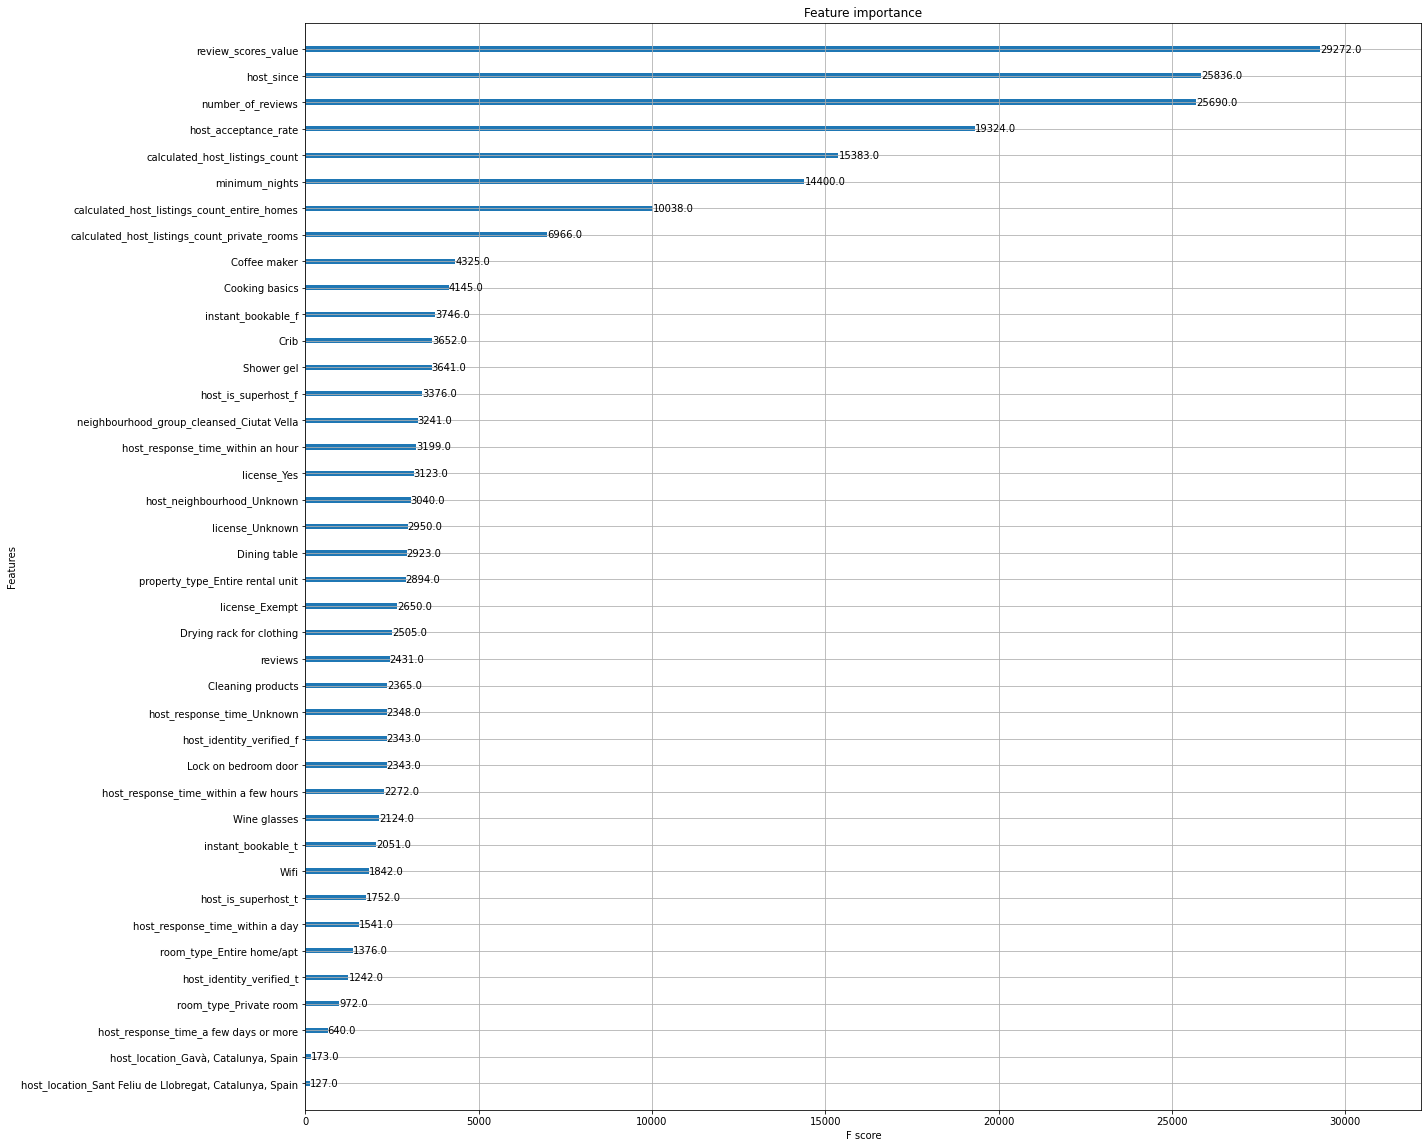

In [100]:
plt.rcParams['figure.figsize'] = [20, 20]
xgb.plot_importance(selection_model3)
plt.show()

In [65]:
params = { 'max_depth': [8,10],
           'learning_rate': [0.01,0.03],
           'n_estimators': [1500,1700,1900],
           'colsample_bytree': [0.35,0.45]}

xgbr = xgb.XGBRegressor(seed = 123)

clf = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=1)

clf.fit(selected_X3, y2)

print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'colsample_bytree': 0.35, 'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 1500}
Lowest RMSE:  1.0759643586928431


In [66]:
params = { 'max_depth': [8,10],
           'learning_rate': [0.01],
           'n_estimators': [1100,1300,1500],
           'colsample_bytree': [0.35,0.45]}

xgbr = xgb.XGBRegressor(seed = 123)

clf = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=1)

clf.fit(selected_X3, y2)

print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'colsample_bytree': 0.35, 'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 1100}
Lowest RMSE:  1.0745224535987519


In [67]:
params = { 'max_depth': [8,9,10],
           'learning_rate': [0.01,0.02],
           'n_estimators': [900,1000,1100],
           'colsample_bytree': [0.35,0.45]}

xgbr = xgb.XGBRegressor(seed = 123)

clf = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=1)

clf.fit(selected_X3, y2)

print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'colsample_bytree': 0.35, 'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 900}
Lowest RMSE:  1.0737921063746148


Best parameters: {'colsample_bytree': 0.35, 'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 900}

In [68]:
params = { 'max_depth': [8,9,10],
           'learning_rate': [0.01,0.02],
           'n_estimators': [700,800,900],
           'colsample_bytree': [0.35,0.45]}

xgbr = xgb.XGBRegressor(seed = 123)

clf = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=1)

clf.fit(selected_X3, y2)

print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

Fitting 5 folds for each of 72 candidates, totalling 360 fits


c:\Users\Andreu\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
90 fits failed out of a total of 360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Andreu\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Andreu\miniconda3\lib\site-packages\xgboost\core.py", line 532, in inner_f
    return f(**kwargs)
  File "c:\Users\Andreu\miniconda3\lib\site-packages\xgboost\sklearn.py", line 961, in fit
    self._Booster = train(
  File "c:\Users\Andreu\miniconda3\lib\site-packages\xgboost\core.py", l

Best parameters: {'colsample_bytree': 0.35, 'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 700}
Lowest RMSE:  1.0736820340512196


Best parameters: {'colsample_bytree': 0.35, 'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 700}

In [101]:
params = {'objective':'reg:linear',
          'max_depth': 9,
          'learning_rate': 0.01,
          'colsample_bytree': 0.35}

data_dmatrix = xgb.DMatrix(data=selected_X3,label=y2)

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5, num_boost_round=700, early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

[18:54:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[18:54:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[18:54:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[18:54:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[18:54:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


In [102]:
cv_results.tail()

train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
695         0.583943        0.003397        0.964663       0.014400
696         0.583529        0.003348        0.964659       0.014420
697         0.583278        0.003349        0.964623       0.014402
698         0.582913        0.003520        0.964609       0.014424
699         0.582629        0.003506        0.964596       0.014420

In [76]:
params = { 'max_depth': [8,9,10],
           'learning_rate': [0.01,0.02],
           'n_estimators': [500,600,700],
           'colsample_bytree': [0.35,0.45]}

xgbr = xgb.XGBRegressor(seed = 123)

clf = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=1)

clf.fit(selected_X3, y2)

print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'colsample_bytree': 0.35, 'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 700}
Lowest RMSE:  1.0736820340512196


Observamos que ya hemos encontrado el mejor modelo para este conjunto de datos con lo que volveremos a recortar el numero de variables y volveremos a intentar a reducir el overfitting.

In [107]:
# select features using threshold
selection = SelectFromModel(selection_model3, threshold=0.0145, prefit=True)
select_X_train4 = selection.transform(select_X_train3)
feature_idx = selection.get_support()
select_X_train4 = pd.DataFrame(select_X_train4, columns=selected_X3.columns[feature_idx])

# train model
selection_model4 = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.35, learning_rate = 0.01, max_depth = 9, n_estimators = 700)
selection_model4.fit(select_X_train4, y2_train)

# eval model
select_X_test4 = selection.transform(select_X_test3)
y2_pred4 = selection_model4.predict(select_X_test4)
train_pred4 = selection_model4.predict(select_X_train4)
select_X_test4 = pd.DataFrame(select_X_test4, columns=selected_X3.columns[feature_idx])

rmse = np.sqrt(mean_squared_error(y2_test, y2_pred4))
print("RMSE: %f" % (rmse))
rmse = np.sqrt(mean_squared_error(y2_train, train_pred4))
print("RMSE: %f" % (rmse))

c:\Users\Andreu\miniconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


[18:57:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 0.988182
RMSE: 0.663507


c:\Users\Andreu\miniconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [108]:
selected_X4 = selected_X3.loc[:,selection.get_support()]
selected_X4.shape

(13252, 28)

Obtenemos una matriz de dimensiones (13252, 28)

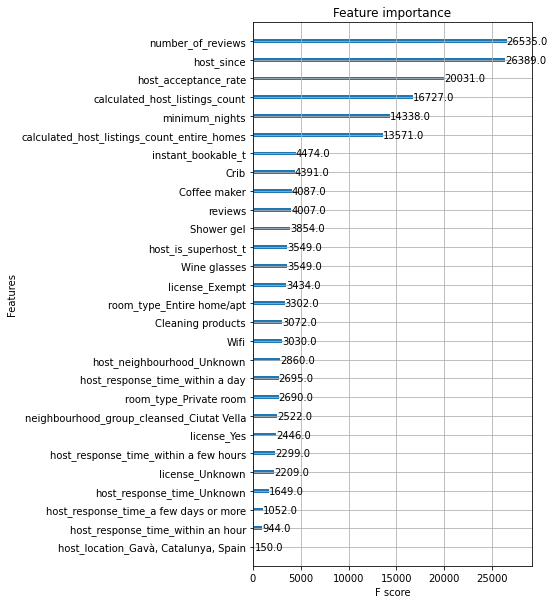

In [114]:
plt.rcParams['figure.figsize'] = [5, 10]
xgb.plot_importance(selection_model4)
plt.show()

In [81]:
params = { 'max_depth': [8,9,10],
           'learning_rate': [0.01,0.02],
           'n_estimators': [500,600,700],
           'colsample_bytree': [0.35,0.45]}

xgbr = xgb.XGBRegressor(seed = 123)

clf = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=1)

clf.fit(selected_X4, y2)

print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'colsample_bytree': 0.45, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 500}
Lowest RMSE:  1.0722627767392956


In [82]:
params = { 'max_depth': [9,10,11],
           'learning_rate': [0.01,0.02],
           'n_estimators': [400,450,500],
           'colsample_bytree': [0.35,0.45]}

xgbr = xgb.XGBRegressor(seed = 123)

clf = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=1)

clf.fit(selected_X4, y2)

print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'colsample_bytree': 0.45, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 450}
Lowest RMSE:  1.0719935154032842


In [110]:
params = {'objective':'reg:linear',
          'max_depth': 10,
          'learning_rate': 0.01,
          'colsample_bytree': 0.45}

data_dmatrix = xgb.DMatrix(data=selected_X4,label=y2)

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5, num_boost_round=450, early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

[18:59:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[18:59:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[18:59:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[18:59:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[18:59:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


In [111]:
cv_results.tail()

train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
445         0.618574        0.005007        0.971707       0.013198
446         0.618161        0.005195        0.971652       0.013165
447         0.617456        0.005064        0.971576       0.013153
448         0.617030        0.004994        0.971540       0.013185
449         0.616290        0.005207        0.971504       0.013120

Ya que parece que no estamos consiguiendo reducir mucho mas el overfitting, vamos a incluir mas parametros los cuales estavan en sus valores por defecto para ver si con estos conseguimos reducirlo.

In [99]:
params = { 'max_depth': [9,10],
           'learning_rate': [0.01],
           'n_estimators': [400,450],
           'colsample_bytree': [0.35,0.45],
           'min_child_weight': [1,5],
           'min_split_loss': [0,5]}

xgbr = xgb.XGBRegressor(seed = 123)

clf = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=1)

clf.fit(selected_X4, y2)

print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best parameters: {'colsample_bytree': 0.45, 'learning_rate': 0.01, 'max_depth': 10, 'min_child_weight': 5, 'min_split_loss': 0, 'n_estimators': 450}
Lowest RMSE:  1.069470894615875


In [112]:
params = {'objective':'reg:linear',
          'max_depth': 10,
          'learning_rate': 0.01,
          'colsample_bytree': 0.45,
          'min_child_weight': 10,
          'min_split_loss': 10}

data_dmatrix = xgb.DMatrix(data=selected_X4,label=y2)

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5, num_boost_round=450, early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

[19:01:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[19:01:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[19:01:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[19:01:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[19:01:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


In [113]:
cv_results.tail()

train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
445         0.865606        0.003090        0.990187       0.014465
446         0.865528        0.003134        0.990161       0.014457
447         0.865282        0.003071        0.990039       0.014441
448         0.865155        0.003072        0.989998       0.014452
449         0.864944        0.003109        0.989903       0.014403

Obtenemos un modelo en el cual se ha reducido el overfitting, lo hemos conseguido a traves de reducir las dimensiones de la matriz y añadir parametros los cuales sirven para reducir el overfitting.

El modelo final para la variable y2 seria: {'objective':'reg:linear', 'max_depth': 10, 'learning_rate': 0.01, 'colsample_bytree': 0.45, 'min_child_weight': 10, 'min_split_loss': 10}

Guardamos tambien la matriz final.

In [110]:
selected_X4.to_csv("E:\Data\TFG\X_y2.csv")